# Chapter 06. Other Issues

In [53]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 매개변수 업데이트
* 매개변수의 기울기(=미분)을 구하기
* 기울어진 방향으로 매개변수를 업데이트
* 이를 반복하면서 최적의 매개변수 값을 찾기

### 1.1. 확률적 경사하강법 (Stochastic Gradient Descent)
#### 1.1.1. 수식
확률적 경사하강법(SGD, Stochastic Gradient Descent)는 **기울어진 방향으로 일정 거리를 가는 단순한 방법**이다.

$$ \textbf{W} \leftarrow \textbf{W} - \eta \frac{\partial L}{\partial \textbf{W}} $$

* $W$ : 업데이트할 Weight값
* $\frac{\partial L}{\partial W}$ : $W$에 대한 손실 함수의 기울기
* $\eta$ : 학습률 (보통 0.01, 0.001)
* $\leftarrow$ : 우변의 값으로 좌변의 값을 업데이트

#### 1.1.2. 단점
SGD는 단순하지만, 때에 따라서 비효율적일 때가 있다. 예를 들어, **밥그릇을 x축 방향으로 늘인 듯한** 함수 $f(x, y) = \frac{1}{20}x^2+y^2$을 보자.

<img src="sgd_cons.png" width=70%>

위의 함수의 기울기를 나타내면 다음과 같다. 방향을 보면 $(0,0)$을 가리키고 있지 않다.

<img src='sgd_gradient.png' width=50%>

이 상태에서 `SGD` 방법을 적용하면, 많이 요동을 치며 최소값으로 가게 된다. 

<img src='sgd_gradient_2.png' width=50%>

In [54]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.key():
            params[key] -= self.lr * grads[key]

### 1.2. 모멘텀 (Momentum)
모멘텀(Momentum, 운동량)은 **기울어진 방향으로 힘을 받아 점점 하강하는 물리법칙을 이용한 방법**이다. 물리에서 `운동량 = 속도 * 질량`이다.

$$ \textbf{v} \leftarrow \alpha \textbf{v} - \eta \frac{\partial L}{\partial \textbf{W}} $$

$$ \textbf{W} \leftarrow \textbf{W} + \textbf{v}$$

* $W$ : 업데이트할 Weight값
* $\frac{\partial L}{\partial W}$ : $W$에 대한 손실 함수의 기울기
* $\eta$ : 학습률 (보통 0.01, 0.001)
* $v$ : 속도(velocity) → $\alpha \textbf{v}$ : 아무런 힘을 받지 않을 때 하강하면서 진폭이 줄어듦 ($\alpha$ = 0.9)

<img src="momentum.png" width=50%>

In [55]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr                 # 학습률
        self.momentum = momentum     # 운동량
        self.v = None                # 속도
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 1.3. AdaGrad
AdaGrad는 **각각의 매개변수에 맞게 학습률을 조정하는 방식**이다.

$$ h \leftarrow h +\frac{\partial L}{\partial W}\circledcirc\frac{\partial L}{\partial W} $$

$$W \leftarrow W + \eta\frac{1}{\sqrt{h}}\frac{\partial L}{\partial W}$$

* $W$ : 업데이트할 Weight값
* $\frac{\partial L}{\partial W}$ : $W$에 대한 손실 함수의 기울기
* $\eta$ : 학습률 (보통 0.01, 0.001)
* $h$ : 기존 기울기의 제곱을 계속 더한 값 → $\eta$에 $\frac{1}{\sqrt{h}}$를 곱해 학습률을 감소시킴

<img src='./adagrad.png' width=50%>

In [56]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr     # 학습률
        self.h = None    # 학습률 감소 정도
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # 0을 나누는 것을 막기 위해 1e-7을 더해줌
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 1.4. Adam
Adam은 Momentum과 AdaGrad 방법을 합친 방법이다.
* Momentum보다는 흔들림이 적고
* AdaGrad처럼 학습률을 각 매개변수에 맞게 조정해준다.

<img src="adam.png" width=50%>

In [57]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### 1.5. MNIST 데이터셋으로 비교

In [58]:
import os
import sys
sys.path.append(os.pardir) 
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

# MNIST 데이터셋 train, test 데이터셋으로 분리 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 하이퍼 파라미터 설정
train_size = x_train.shape[0]
batch_size = 128         # 배치 크기
max_iterations = 2000    # 최대 반복 학습 횟수

# 매개변수를 업데이트 하는 클래스
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}

# 각 방법에 맞게 신경망 생성
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

# 반복 학습 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 각 방법에 따라 매개변수 업데이트
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 400 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
SGD:2.329462964208279
Momentum:2.353505914093831
AdaGrad:2.2812504864858267
Adam:2.1848919982645825
===========iteration:400===========
SGD:0.2703501537018702
Momentum:0.09604892565071138
AdaGrad:0.026847351591047078
Adam:0.07043118503314785
===========iteration:800===========
SGD:0.37633249767012206
Momentum:0.15764325140779234
AdaGrad:0.1216221146376088
Adam:0.14140055471404628
===========iteration:1200===========
SGD:0.19665359885317024
Momentum:0.14673806666828326
AdaGrad:0.05978269602731475
Adam:0.0651313633103199
===========iteration:1600===========
SGD:0.28559741726905075
Momentum:0.12128353267382902
AdaGrad:0.07265619216575758
Adam:0.07887384628865513


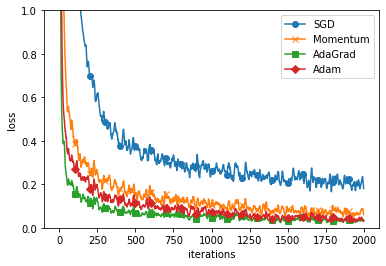

In [59]:
# 각 방법에 따른 손실 함수값 변화의 정도
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}

x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)

plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 2. Weight의 초기값 설정

### 2.1. Weight의 초기값
#### 2.1.1. 0으로 설정
오버피팅을 막기 위한 방법 중 하나로 **가중치 감소**가 있다. 이는 **가중치 매개변수의 값이 작아지도록 학습하는 것**이다. 그럼 초기값으로 `0`을 설정하면 어떻게 될까?      

그러면 오차역전파법에 의해서 모든 가중치의 값이 같은 값으로 갱신되기 때문에 여러 개의 가중치를 갖는 의미가 없어진다. 이렇게 **가중치가 고르게 되어버리는 상황**을 막기 위해서 **가중치의 초기값을 임의로 설정**해야 한다.

#### 2.1.2. 은닉층의 활성화값
은닉층의 활성화 값은 **활성화 함수의 출력값**을 의미한다. 가중치의 초기값에 따라 이 활성화 값은 달라진다.

In [60]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 정규분포를 가지고 있는 1000개의 데이터 생성 (가중치는 10개)
x = np.random.randn(1000, 100)
# 은닉층의 뉴런 수 
node_num = 100
# 은닉층의 개수
hidden_layer_size = 5
# 활성화 값(=활성화 함수의 출력 값) 기록
activations = {}

In [61]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # 표준편차 1
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

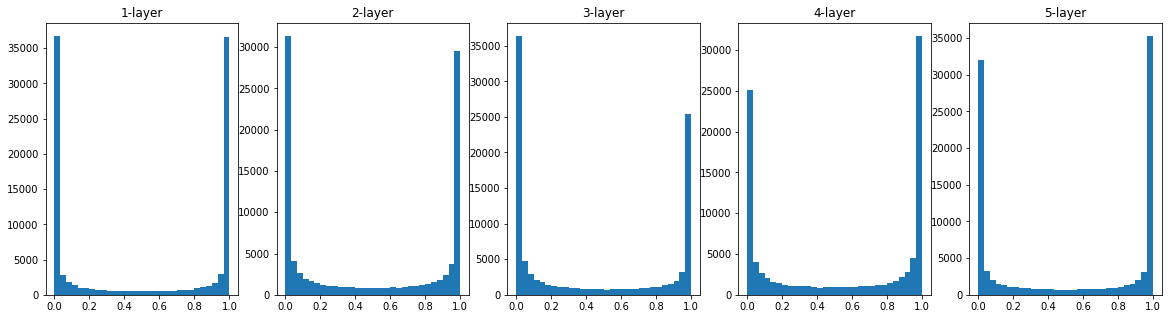

In [62]:
plt.figure(figsize=(20, 5))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

각 층의 활성화 값들이 0과 1에 치우쳐 있다. 점점 층이 깊어지고 출력이 0에 가까워지면서 미분은 0에 점점 더 가까워진다. 그렇게 되면 역전파의 기울기가 점점 작아지다가 사라지는데 이를 **기울기 소실**이라고 한다.

In [63]:
# 정규분포를 가지고 있는 1000개의 데이터 생성 (가중치는 10개)
x = np.random.randn(1000, 100)
# 은닉층의 뉴런 수 
node_num = 100
# 은닉층의 개수
hidden_layer_size = 5
# 활성화 값(=활성화 함수의 출력 값) 기록
activations = {}

In [64]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # 표준편차 0.01
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

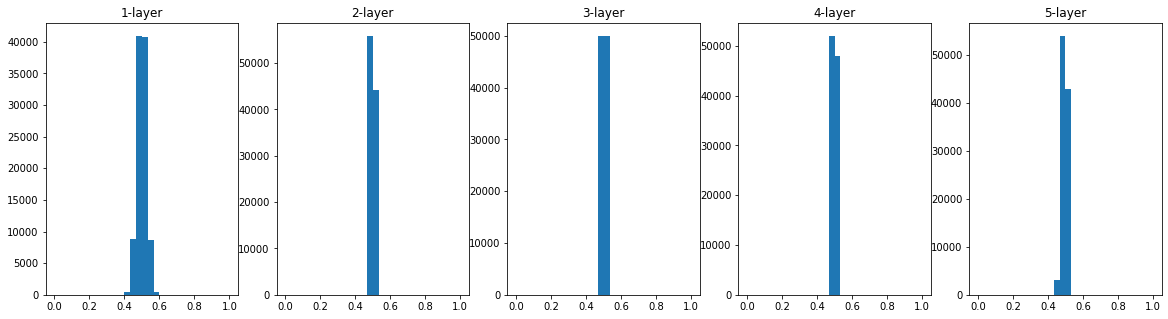

In [65]:
plt.figure(figsize=(20, 5))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

각 층의 활성화 값들이 0.5에 치우쳐 있다. 0과 1로 치우치지는 않아 기울기 소실이 일어나지는 않지만, 한 값으로 치우쳐져 많은 뉴런이 같은 값을 출력해 뉴런을 여러 개 둔 의미가 없어지는 **표현력 제한 문제**가 발생한다.

`결론!` 우리는 각 층의 활성화값이 **골고루 분포**가 되도록 **가중치의 초기값을 잘 설정**해야 한다. 즉, 적절한 분포를 찾아야 한다.

### 2.2. Xavier 초기값
앞 계층의 노드가 $n$개 일 때, **표준 편차가 $\frac{1}{\sqrt{n}}$인 분포**를 사용하면 층이 깊어지면서 모양이 살짝 일그러지지만, 넓게 분포되는 걸 볼 수 있다.

In [73]:
# 정규분포를 가지고 있는 1000개의 데이터 생성 (가중치는 10개)
x = np.random.randn(1000, 100)
# 은닉층의 뉴런 수 
node_num = 100
# 은닉층의 개수
hidden_layer_size = 5
# 활성화 값(=활성화 함수의 출력 값) 기록
activations = {}

In [74]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

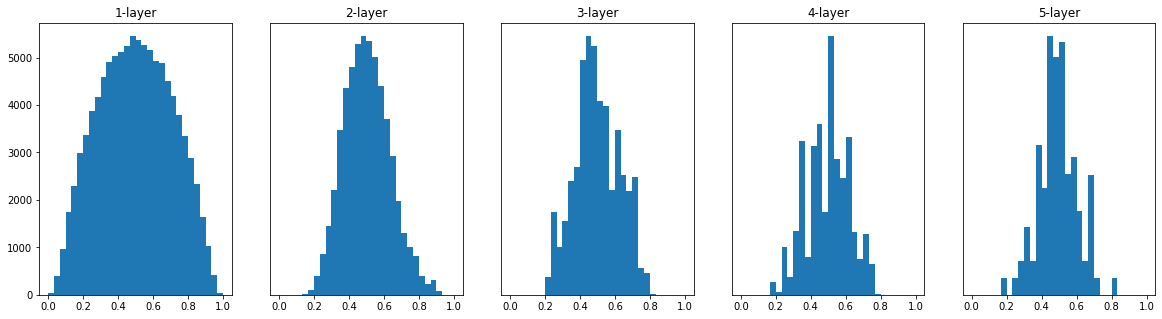

In [78]:
plt.figure(figsize=(20, 5))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    
    if i != 0: 
        plt.yticks([], [])
        
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### 2.3. He 초기값
Xavier 초기값은 **활성화 함수가 선형 함수인 것을 전제로 한 값**이다. 반면 ReLU함수는 선형 함수가 아니기에 이에 맞춰진 초기값을 사용하는 것이 좋다. 이 초기값을 **He 초기값**이라고 하는데 앞 계층의 노드가 $n$개 일 때, **표준 편차가 $\sqrt{\frac{2}{n}}$인 분포**를 사용한다.

In [79]:
def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 5개의 은닉층
activations = {}                # 이곳에 활성화 결과(활성화값)을 저장

In [80]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # he 초기값
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    a = np.dot(x, w)
    z = ReLU(a)
    
    activations[i] = z

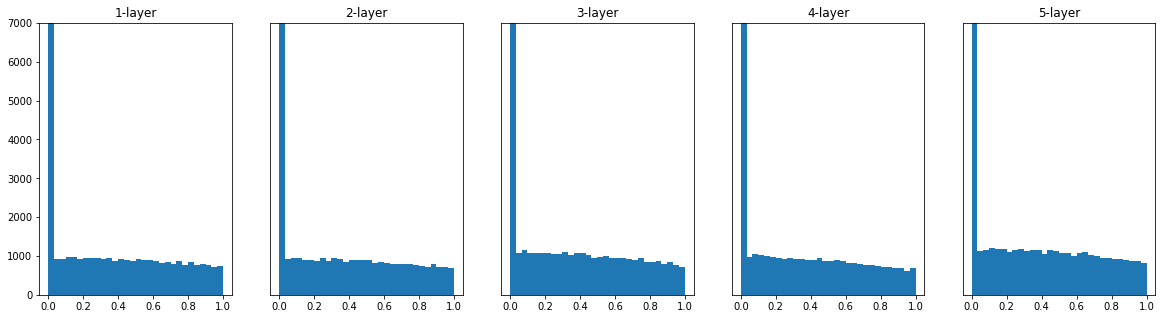

In [82]:
plt.figure(figsize=(20, 5))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    
    if i != 0: 
        plt.yticks([], [])
    
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))     
    
plt.show()

### 2.4. MNIST 데이터셋으로 비교
활성화 함수는 `relu` 함수이다.

In [83]:
import os, sys
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# train과 test 데이터로 분리
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]

# 하이퍼 파라미터 설정
batch_size = 128        # 배치 크기
max_iterations = 2000   # 최대 반복 횟수

# 가중치 초기값 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}

# 매개변수 업데이트 방식 : SGD
optimizer = SGD(lr=0.01)

networks = {}    # 신경망
train_loss = {}  # 손실 함수 값 기록

for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 반복 학습
for i in range(max_iterations):
    # 배치 추출
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 매개변수 업데이트
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 200 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
std=0.01:2.302566827177138
Xavier:2.2947779853411276
He:2.4058525888186093
===========iteration:200===========
std=0.01:2.302511465150065
Xavier:2.12020375349796
He:0.6877036734027482
===========iteration:400===========
std=0.01:2.3008009917660006
Xavier:1.3340001009414382
He:0.4717134139036108
===========iteration:600===========
std=0.01:2.2988020517834284
Xavier:0.6607980520118159
He:0.24119129643212778
===========iteration:800===========
std=0.01:2.306980519436004
Xavier:0.5565073152907978
He:0.3229578534976204
===========iteration:1000===========
std=0.01:2.3034157263618638
Xavier:0.36573825598339244
He:0.25232710582482354
===========iteration:1200===========
std=0.01:2.296237189532991
Xavier:0.4318146126263217
He:0.32222925784142853
===========iteration:1400===========
std=0.01:2.297189621627905
Xavier:0.286135966379535
He:0.19689016587311015
===========iteration:1600===========
std=0.01:2.2939279407092084
Xavier:0.21498290668117528
He:0.141780508

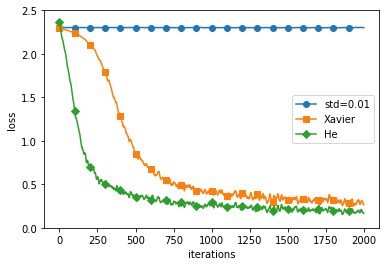

In [84]:
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)

for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)

plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 3. 배치 정규화
배치 정규화란 **데이터 분포를 정규화하는 `배치 정규화 계층`을 신경망에 넣는 것**이다. 즉, 학습할 때 미니 배치를 단위로 정규화를 진행한다. 결국에는 알아서 넓게 펴주는 것.
* `장점1` : 학습 속도가 빨라진다.
* `장점2` : 가중치의 초기값에 따라 결과가 크게 바뀌지 않는다. (초기값의 분포가 상관이 없음)
* `장점3` : 오버피팅이 일어날 가능성을 줄여준다.

<img src="batch_standardization.png" width=70%>

----
1. 우선 분포가 평균이 0, 분산이 1이 되도록 정규화한다.
    * $B = {x_1, x_2, ... x_m}$ : $m$개의 입력 데이터
    * $\mu_B$ : 데이터의 평균
    * $\sigma_B^2$ : 데이터의 분산
    * $\epsilon$ : 0으로 나누어지는 것을 방지하기 위한 아주 작은 값

$$\mu_{B} \leftarrow \frac{1}{m}\sum_{i=1}^mx_i$$

$$\sigma^2_B \leftarrow \frac{1}{m}\sum_{i=1}^m(x_i - \mu_B)^2$$

$$\hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$

----
2. 그 다음에 **고유한 확대(scale)**와 **이동 변환(shift)**를 수행한다.학습을 하면서 $\gamma$, $\beta$가 적절한 값으로 조정이 된다.
    * $\gamma$ : 확대를 담당 (1에서 시작)
    * $\beta$ : 이동을 담당 (0에서 시작)
    
$$y_i \leftarrow \gamma\hat{x}_i +\beta$$
    
----

<img src='./batch_standard_compare.png' width=60%>

## 4. 더 좋은 학습
### 4.1. 오버피팅
오버피팅이란 **신경망이 학습 데이터에만 지나치게 학습되어 그 외에 새로운 데이터에는 제대로 예측하지 못하는 것**을 말한다. 오버피팅은 주로 다음과 같은 상황에서 일어난다.
* 매개변수가 많고 표현력이 높은 모델일 때
* 학습 데이터가 적을 때

In [85]:
import os, sys
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터 중 300개만 사용
x_train = x_train[:300]
t_train = t_train[:300]

# 7층 신경망을 써서 복잡하게 만듦
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.11666666666666667, test acc:0.1037
epoch:1, train acc:0.14, test acc:0.1142
epoch:2, train acc:0.17333333333333334, test acc:0.1277
epoch:3, train acc:0.19666666666666666, test acc:0.1413
epoch:4, train acc:0.22333333333333333, test acc:0.1575
epoch:5, train acc:0.25333333333333335, test acc:0.1744
epoch:6, train acc:0.2833333333333333, test acc:0.1924
epoch:7, train acc:0.29, test acc:0.2111
epoch:8, train acc:0.31, test acc:0.2251
epoch:9, train acc:0.3466666666666667, test acc:0.2494
epoch:10, train acc:0.37666666666666665, test acc:0.2662
epoch:11, train acc:0.4033333333333333, test acc:0.2818
epoch:12, train acc:0.4, test acc:0.2928
epoch:13, train acc:0.42, test acc:0.3046
epoch:14, train acc:0.45, test acc:0.3236
epoch:15, train acc:0.4666666666666667, test acc:0.3371
epoch:16, train acc:0.4866666666666667, test acc:0.3511
epoch:17, train acc:0.5133333333333333, test acc:0.3651
epoch:18, train acc:0.53, test acc:0.3813
epoch:19, train acc:0.5233333333333333,

epoch:157, train acc:0.9966666666666667, test acc:0.747
epoch:158, train acc:0.9966666666666667, test acc:0.7478
epoch:159, train acc:1.0, test acc:0.7479
epoch:160, train acc:1.0, test acc:0.7472
epoch:161, train acc:1.0, test acc:0.7481
epoch:162, train acc:1.0, test acc:0.7483
epoch:163, train acc:1.0, test acc:0.7494
epoch:164, train acc:1.0, test acc:0.7481
epoch:165, train acc:1.0, test acc:0.748
epoch:166, train acc:1.0, test acc:0.7472
epoch:167, train acc:1.0, test acc:0.7471
epoch:168, train acc:1.0, test acc:0.7496
epoch:169, train acc:1.0, test acc:0.748
epoch:170, train acc:1.0, test acc:0.7496
epoch:171, train acc:1.0, test acc:0.7492
epoch:172, train acc:1.0, test acc:0.7485
epoch:173, train acc:1.0, test acc:0.7486
epoch:174, train acc:1.0, test acc:0.7495
epoch:175, train acc:1.0, test acc:0.7478
epoch:176, train acc:1.0, test acc:0.749
epoch:177, train acc:1.0, test acc:0.7504
epoch:178, train acc:1.0, test acc:0.7513
epoch:179, train acc:1.0, test acc:0.7513
epoch:18

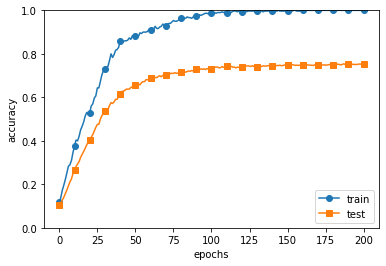

In [86]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)

plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 4.2. 가중치 감소
오버피팅을 방지하기 위한 방법으로는 **가중치 감소(weight decay)**가 있다. 가중치 감소란 **학습하는 동안 큰 가중치에 대해서는 큰 패널티를 부여하는 것**이다. 즉, 큰 가중치에게는 그 가중치에 대한 손실함수의 값에 더 큰 값을 더하여 손실 함수의 값을 더 크게 만든다.

----

$\frac{1}{2}\lambda W^2$(L2 Norm)을 각 가중치의 손실 함수에 더해준다. 그리고 오차역전파법에 의해 그 미분값인 $\lambda W$이 기울기에 더해진다.

* $W$ : 가중치
* $\lambda$ : 정규화의 세기를 조절하는 하이퍼파라미터 (값이 클수록 패널티가 증가)
* $\frac{1}{2}$ : $\frac{1}{2}\lambda W^2$의 미분 결과인 $\lambda W$를 조정하는 상수

In [87]:
import os, sys
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터 중 300개만 사용
x_train = x_train[:300]
t_train = t_train[:300]

# 7층 신경망을 써서 복잡하게 만듦
# 가중치 감소 lambda = 0.1
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, weight_decay_lambda=0.1)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.08333333333333333, test acc:0.0914
epoch:1, train acc:0.09, test acc:0.0961
epoch:2, train acc:0.10333333333333333, test acc:0.1099
epoch:3, train acc:0.15333333333333332, test acc:0.1259
epoch:4, train acc:0.17666666666666667, test acc:0.1572
epoch:5, train acc:0.21666666666666667, test acc:0.1795
epoch:6, train acc:0.23333333333333334, test acc:0.2052
epoch:7, train acc:0.26, test acc:0.2302
epoch:8, train acc:0.29, test acc:0.2453
epoch:9, train acc:0.31, test acc:0.2688
epoch:10, train acc:0.35333333333333333, test acc:0.2748
epoch:11, train acc:0.3466666666666667, test acc:0.2742
epoch:12, train acc:0.37, test acc:0.2901
epoch:13, train acc:0.3933333333333333, test acc:0.3019
epoch:14, train acc:0.42, test acc:0.3284
epoch:15, train acc:0.44, test acc:0.3312
epoch:16, train acc:0.44333333333333336, test acc:0.3328
epoch:17, train acc:0.48, test acc:0.3569
epoch:18, train acc:0.49, test acc:0.3552
epoch:19, train acc:0.52, test acc:0.3646
epoch:20, train acc:0.

epoch:161, train acc:0.93, test acc:0.7449
epoch:162, train acc:0.94, test acc:0.7506
epoch:163, train acc:0.93, test acc:0.7458
epoch:164, train acc:0.9333333333333333, test acc:0.7552
epoch:165, train acc:0.9333333333333333, test acc:0.7492
epoch:166, train acc:0.9266666666666666, test acc:0.7498
epoch:167, train acc:0.93, test acc:0.7453
epoch:168, train acc:0.9266666666666666, test acc:0.7492
epoch:169, train acc:0.9333333333333333, test acc:0.7501
epoch:170, train acc:0.93, test acc:0.7476
epoch:171, train acc:0.93, test acc:0.7502
epoch:172, train acc:0.9233333333333333, test acc:0.7496
epoch:173, train acc:0.9233333333333333, test acc:0.7405
epoch:174, train acc:0.9333333333333333, test acc:0.7484
epoch:175, train acc:0.9266666666666666, test acc:0.7489
epoch:176, train acc:0.9233333333333333, test acc:0.7465
epoch:177, train acc:0.94, test acc:0.7591
epoch:178, train acc:0.9333333333333333, test acc:0.7564
epoch:179, train acc:0.9433333333333334, test acc:0.7537
epoch:180, trai

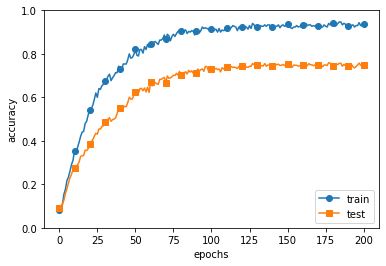

In [88]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)

plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 4.3. Drop Out
<img src="dropout.png" width=50%>

오버피팅을 방지하기 위한 다른 방법으로 **드롭 아웃(drop out)**이 있다. 드롭 아웃이란 **뉴런들을 임의로 삭제하면서 학습하는 방법**이다. 즉, 학습할 때 데이터를 흘릴 때마다 삭제할 뉴런을 임의로 선택하고, 테스트 때는 모든 뉴런에 신호를 전달한다.

`forward` 메서드에서 학습 시(`train_flg = True`) 잘 계산해두면 테스트 시에는 데이터를 흘려주기만 하면 된다.

In [89]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        # 이 값을 넘어야 데이터가 흘러간다.
        self.dropout_ratio = dropout_ratio  
        self.mask = None

    def forward(self, x, train_flg=True):
        # 학습 시
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        # 테스트 시
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [93]:
import os, sys
sys.path.append(os.pardir) 
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 여부
use_dropout = True
dropout_ratio = 0.15


network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, 
                        use_dropout=use_dropout, dropout_ration=dropout_ratio)
   
max_epochs = 301
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.10333333333333333, test acc:0.1217
epoch:1, train acc:0.11, test acc:0.1278
epoch:2, train acc:0.11333333333333333, test acc:0.1342
epoch:3, train acc:0.12, test acc:0.1361
epoch:4, train acc:0.12333333333333334, test acc:0.1376
epoch:5, train acc:0.12333333333333334, test acc:0.1383
epoch:6, train acc:0.13, test acc:0.1412
epoch:7, train acc:0.13666666666666666, test acc:0.1451
epoch:8, train acc:0.14, test acc:0.1469
epoch:9, train acc:0.14, test acc:0.1501
epoch:10, train acc:0.14, test acc:0.154
epoch:11, train acc:0.13666666666666666, test acc:0.1577
epoch:12, train acc:0.14333333333333334, test acc:0.1612
epoch:13, train acc:0.14666666666666667, test acc:0.1662
epoch:14, train acc:0.15666666666666668, test acc:0.1684
epoch:15, train acc:0.16333333333333333, test acc:0.1728
epoch:16, train acc:0.18, test acc:0.1764
epoch:17, train acc:0.18333333333333332, test acc:0.1817
epoch:18, train acc:0.17666666666666667, test acc:0.1844
epoch:19, train acc:0.18666666666

epoch:161, train acc:0.6733333333333333, test acc:0.5372
epoch:162, train acc:0.6766666666666666, test acc:0.5423
epoch:163, train acc:0.69, test acc:0.5544
epoch:164, train acc:0.6833333333333333, test acc:0.5562
epoch:165, train acc:0.68, test acc:0.5569
epoch:166, train acc:0.69, test acc:0.5518
epoch:167, train acc:0.6866666666666666, test acc:0.5602
epoch:168, train acc:0.6833333333333333, test acc:0.5628
epoch:169, train acc:0.6933333333333334, test acc:0.564
epoch:170, train acc:0.69, test acc:0.5672
epoch:171, train acc:0.6966666666666667, test acc:0.569
epoch:172, train acc:0.6966666666666667, test acc:0.5698
epoch:173, train acc:0.6966666666666667, test acc:0.5721
epoch:174, train acc:0.6966666666666667, test acc:0.5769
epoch:175, train acc:0.7066666666666667, test acc:0.5755
epoch:176, train acc:0.6966666666666667, test acc:0.575
epoch:177, train acc:0.6966666666666667, test acc:0.5751
epoch:178, train acc:0.6966666666666667, test acc:0.5786
epoch:179, train acc:0.7, test ac

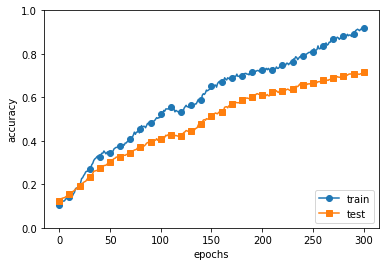

In [94]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))

plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 5. 적절한 하이퍼파리미터
하이퍼파라미터(hyper parameter)란 **사람이 설정하는 매개변수**를 뜻한다. 예를 들어, 각 층의 뉴런의 수, 배치의 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등이 있다.

### 5.1. 검증 데이터
하이퍼파라미터의 성능을 평가할 때 **절대로 테스트 데이터를 사용하면 안** 된다. 그렇게 되면 테스트 데이터에 맞는 하이퍼파라미터로 설정되기 때문이다. 즉, 테스트 데이터에 오버피팅이 된다.

이를 위해 따로 검증 데이터를 두는데 보통 학습 데이터의 20% 정도를 검증 데이터로 사용한다.
* `학습 데이터` : 매개변수 학습
* `검증 데이터` : 하이퍼파라미터 성능 평가
* `시험 데이터` : 신경망의 성능 평가

### 5.2. 하이퍼파라미터 최적화
최적의 하이퍼파라미터의 **범위를 대략적으로 설정**하고, 그 범위에서 무작위로 하이퍼파리미터 값을 골라서 그 값으로 정확도를 평가한다.
1. 하이퍼파라미터 값의 범위를 설정
2. 범위 내에서 하이퍼파라미터의 값을 무작위로 추출
3. 추출한 하이퍼파라미터 값으로 학습하고, 검증데이터로 정확도를 평가 (epoch는 작게 설정)
4. 여러 번 반복하여 정확도를 보고 범위를 좁힘